In [1]:
%matplotlib inline
import pandas as pd
import reverse_geocoder
import geopy.distance

In [2]:
df=pd.read_csv("taxi-trips.csv") 
df.dropoff_datetime=pd.to_datetime(df.dropoff_datetime)
df.pickup_datetime=pd.to_datetime(df.pickup_datetime)

In [3]:
df.shape

(118185, 11)

In [4]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,118185.000000,118185.000000,118185.000000,118185.000000,118185.000000,118185.000000,118185.000000
mean,1.534958,1.657148,-73.973971,40.751392,-73.973538,40.752212,927.186310
std,0.498779,1.313844,0.040456,0.027958,0.039192,0.032284,3118.710246
min,1.000000,0.000000,-79.487900,40.225803,-79.487900,40.225800,1.000000
25%,1.000000,1.000000,-73.991875,40.737835,-73.991394,40.736462,393.000000
50%,2.000000,1.000000,-73.981796,40.754501,-73.979759,40.754848,652.000000
75%,2.000000,2.000000,-73.967575,40.768471,-73.962990,40.770077,1048.000000
max,2.000000,6.000000,-73.425018,41.292198,-73.055977,41.292198,86366.000000


In [5]:
df.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

In [6]:
pickup_geocode=reverse_geocoder.search(list (zip(df.pickup_latitude, df.pickup_longitude)))

Loading formatted geocoded file...


In [7]:
pickup_geocode

[OrderedDict([('lat', '40.78343'),
              ('lon', '-73.96625'),
              ('name', 'Manhattan'),
              ('admin1', 'New York'),
              ('admin2', 'New York County'),
              ('cc', 'US')]),
 OrderedDict([('lat', '40.74482'),
              ('lon', '-73.94875'),
              ('name', 'Long Island City'),
              ('admin1', 'New York'),
              ('admin2', 'Queens County'),
              ('cc', 'US')]),
 OrderedDict([('lat', '40.76955'),
              ('lon', '-74.02042'),
              ('name', 'Weehawken'),
              ('admin1', 'New Jersey'),
              ('admin2', 'Hudson County'),
              ('cc', 'US')]),
 OrderedDict([('lat', '40.78343'),
              ('lon', '-73.96625'),
              ('name', 'Manhattan'),
              ('admin1', 'New York'),
              ('admin2', 'New York County'),
              ('cc', 'US')]),
 OrderedDict([('lat', '40.71427'),
              ('lon', '-74.00597'),
              ('name', 'New York City'),

In [8]:
df["pickup_district"]=[i["name"] for i in pickup_geocode]

In [9]:
dropoff_geocode=reverse_geocoder.search(list (zip(df.dropoff_latitude, df.dropoff_longitude)))

In [10]:
df["dropoff_district"]=[i["name"] for i in dropoff_geocode]

In [11]:
pickup_count=df.pickup_district.value_counts().head(5)
pickup_count

Manhattan           45329
New York City       34625
Long Island City    17787
Weehawken           11334
The Bronx            2777
Name: pickup_district, dtype: int64

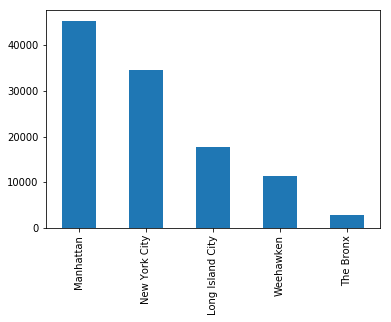

In [12]:
pickup_count.plot.bar()

In [13]:
dropoff_count=df.dropoff_district.value_counts().head(5)
dropoff_count

Manhattan           44478
New York City       31082
Long Island City    19919
Weehawken           10621
Brooklyn             2059
Name: dropoff_district, dtype: int64

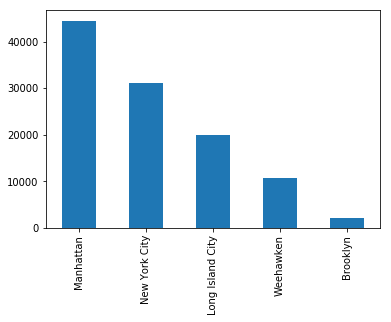

In [14]:
dropoff_count.plot.bar()

In [15]:
def distance (row):
    return geopy.distance.geodesic((row.pickup_latitude, row.pickup_longitude),
                                   (row.dropoff_latitude, row.dropoff_longitude)).kilometers
df["distance"]=df.apply(distance, axis=1)

In [16]:
def timeday(t):
    if 7<=t.hour<9:
        return "rush hour morning"
    elif 9<=t.hour<16:
        return "afternoon"
    elif 16<=t.hour<18:
        return "rush hour evening"
    elif 18<=t.hour<23:
        return "evening"
    else:
        return "latenight"
df["time_of_day"]=df.pickup_datetime.apply(timeday)


In [17]:
dt = df[["time_of_day","distance"]].groupby("time_of_day").mean()
dt

,distance
time_of_day,
afternoon,3.109986
evening,3.378136
latenight,4.117635
rush hour evening,3.342814
rush hour morning,3.128280


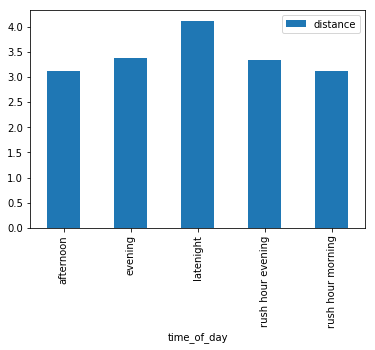

In [18]:
dt.plot(kind="bar")

In [19]:
def get_minutes(x):
    return x.total_seconds()/60

df['duration'] = (df.dropoff_datetime-df.pickup_datetime).apply(get_minutes)

dt = df[["time_of_day","duration"]].groupby("time_of_day").mean()

dt

,duration
time_of_day,
afternoon,16.065379
evening,14.893255
latenight,14.434924
rush hour evening,17.074909
rush hour morning,15.308145


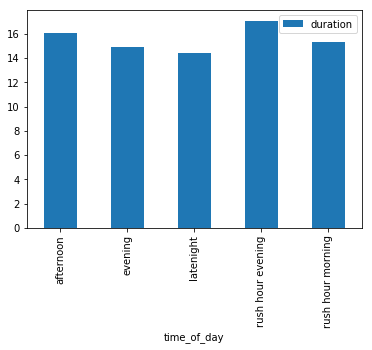

In [20]:
dt.plot(kind="bar")

Hypothesis Testing

In [21]:
singlepass = df[ df.passenger_count==1 ].distance
grouppass = df[ df.passenger_count>1 ].distance

from scipy.stats import ttest_ind

t = ttest_ind(singlepass, grouppass)

if t.pvalue<0.05:
    print("REJECT NULL HYPOTHESIS")
else:
    print("CANT REJECT NULL HYPOTHESIS")    

REJECT NULL HYPOTHESIS


In [22]:
weekend = df[df.pickup_datetime.apply(lambda x:x.weekday()>4)].distance
week = df[df.pickup_datetime.apply(lambda x:x.weekday()<=4)].distance

t = ttest_ind(weekend, week)

if t.pvalue<0.05:
    print("REJECT NULL HYPOTHESIS")
else:
    print("CANT REJECT NULL HYPOTHESIS")    

REJECT NULL HYPOTHESIS
